# Resume Dataset Analysis
## CareerMatch AI - Data Exploration

This notebook analyzes the resume dataset to understand its structure, quality, and prepare for the ML pipeline development.

---
## 1. Setup and Data Loading

In [1]:
%pip install pandas matplotlib seaborn numpy scikit-learn beautifulsoup4 requests tqdm

You should consider upgrading via the '/Users/pratik/Desktop/CU Boulder/OOPS/career-match/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from bs4 import BeautifulSoup
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_colwidth', 200)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [ ]:
# Load the dataset
DATA_DIR = '../data/'
RESUMES_PATH = DATA_DIR + 'raw/pdfs/'
PROCESSED_PATH = DATA_DIR + 'processed/'

df = pd.DataFrame(columns=['ID', 'Category', 'Resume_text'])

# read all the folders
categories = os.listdir(RESUMES_PATH)
print(f"Categories found: {categories}")

Categories found: ['AGRICULTURE', 'ARTS', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'CHEF', 'HEALTHCARE', 'PUBLIC-RELATIONS', 'AVIATION', 'BANKING', 'ACCOUNTANT', 'INFORMATION-TECHNOLOGY', 'HR', 'CONSTRUCTION', 'DESIGNER', 'FINANCE', 'FITNESS', 'BUSINESS-DEVELOPMENT', 'APPAREL', 'ADVOCATE', 'BPO', 'TEACHER', 'ENGINEERING', 'AUTOMOBILE']


In [4]:
def read_pdf_text(file_path):
    import pypdf
    try:
        reader = pypdf.PdfReader(file_path)
        full_text = ""
        for page in reader.pages:
            full_text += page.extract_text() + "\n"  # Add a newline for readability between pages
        return full_text
    except Exception as e:
        print(f"Error reading PDF: {e}")
        return ""

In [5]:
try:
    for category in categories:
        category_path = os.path.join(RESUMES_PATH, category)
        if not os.path.isdir(category_path):
            continue

        files = [f for f in os.listdir(category_path) if f.endswith(".pdf")]

        for file in tqdm(files, desc=f"Processing {category:20}"):
            file_path = os.path.join(category_path, file)
            resume_text = read_pdf_text(file_path)
            df.loc[len(df)] = [file[:-4], category, resume_text]

except KeyboardInterrupt:
    print("Interrupted")

Processing AUTOMOBILE          : 100%|██████████| 36/36 [00:03<00:00,  9.58it/s]


In [6]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   object
 1   Category     2484 non-null   object
 2   Resume_text  2484 non-null   object
dtypes: object(3)
memory usage: 77.6+ KB


In [7]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

Missing Values:
ID             0
Category       0
Resume_text    0
dtype: int64

Duplicate Rows: 0


In [8]:
# Preview sample data
df.head(3)

,ID,Category,Resume_text
0,37201447,AGRICULTURE,ADULT EDUCATION INSTRUCTOR\nSummary\nSeasoned Agriculture Teacher with more than 20 years of experience in this world of education. Excellent teaching and leadership skills. Track\nrecord of achie...
1,12674256,AGRICULTURE,FINANCIAL SALES CONSULTANT\nProfessional Summary\nArticulate Project Manager driven to succeed. Strategic planning and client relationship management expert.\nCore Qualifications\nWritten Communic...
2,29968330,AGRICULTURE,"EXTENSION METHODOLOGIST\nProfile\nSelf-motivated, honest, competent, innovative and easily adapt to new ideas. The knowledge and experience I have evidently accumulated through\nmy academics at va..."


In [ ]:
# save to csv for future use
df.to_csv(PROCESSED_PATH + 'Resume.csv', index=False)

---
## 2. Category Distribution Analysis

In [10]:
# Category counts
category_counts = df['Category'].value_counts()
print("Category Distribution:")
print(category_counts)

Category Distribution:
Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ACCOUNTANT                118
ADVOCATE                  118
FINANCE                   118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
HEALTHCARE                115
BANKING                   115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


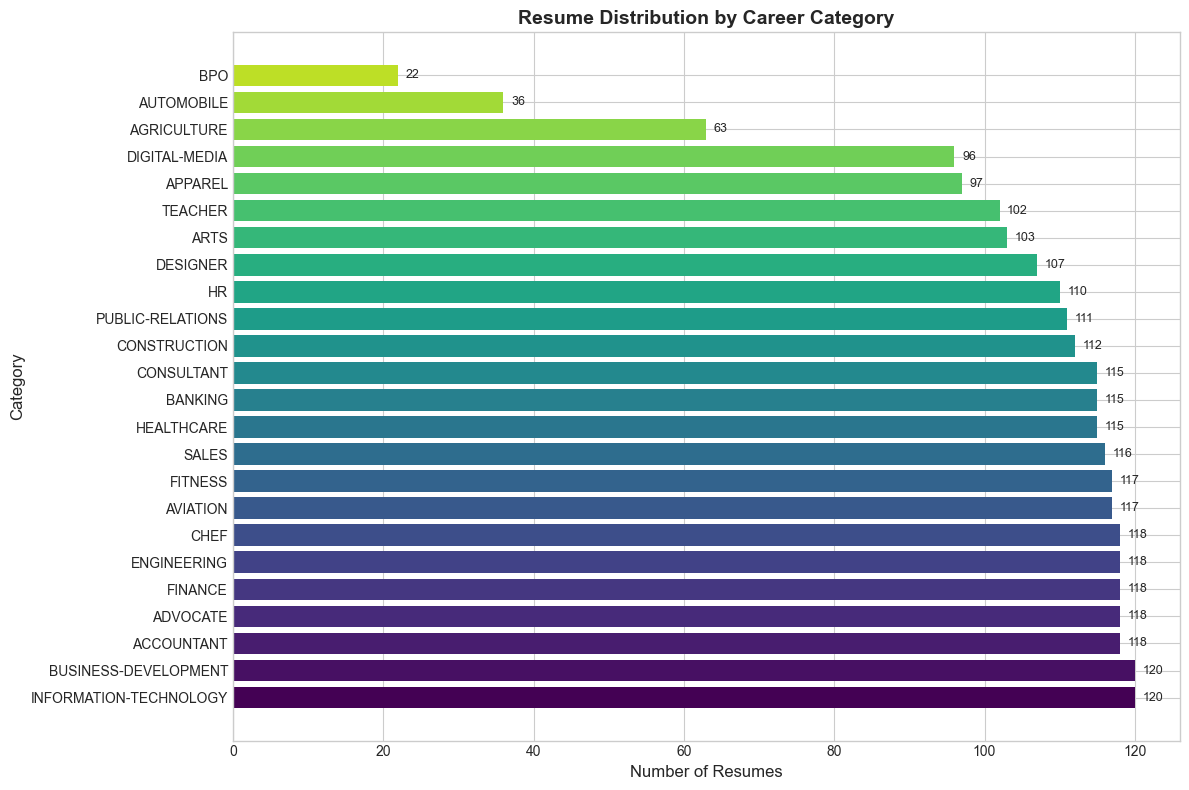


Total Categories: 24
Average per Category: 103.5
Min: 22 (BPO)
Max: 120 (INFORMATION-TECHNOLOGY)


In [11]:
# Visualize category distribution
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(category_counts)))
bars = ax.barh(category_counts.index, category_counts.values, color=colors)

ax.set_xlabel('Number of Resumes', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
ax.set_title('Resume Distribution by Career Category', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, category_counts.values):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2, str(val), va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTotal Categories: {len(category_counts)}")
print(f"Average per Category: {category_counts.mean():.1f}")
print(f"Min: {category_counts.min()} ({category_counts.idxmin()})")
print(f"Max: {category_counts.max()} ({category_counts.idxmax()})")

---
## 3. Text Cleaning and Preprocessing

In [12]:
def clean_html(html_text):
    """Remove HTML tags and clean text"""
    if pd.isna(html_text):
        return ""
    soup = BeautifulSoup(html_text, 'html.parser')
    text = soup.get_text(separator=' ')
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_resume_text(text):
    """Basic cleaning of resume text"""
    if pd.isna(text):
        return ""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove email addresses (but store them for analysis)
    text = re.sub(r'\S+@\S+', ' [EMAIL] ', text)
    # Remove phone numbers (basic pattern)
    text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', ' [PHONE] ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['Clean_Text'] = df['Resume_text'].apply(clean_resume_text)
print("Text cleaning completed!")

Text cleaning completed!


In [13]:
# Compare original vs cleaned
sample_idx = 0
print("=" * 50)
print("ORIGINAL TEXT (first 500 chars):")
print("=" * 50)
print(df['Resume_text'].iloc[sample_idx][:500])
print("\n" + "=" * 50)
print("CLEANED TEXT (first 500 chars):")
print("=" * 50)
print(df['Clean_Text'].iloc[sample_idx][:500])

ORIGINAL TEXT (first 500 chars):
ADULT EDUCATION INSTRUCTOR
Summary
Seasoned Agriculture Teacher with more than 20 years of experience in this world of education. Excellent teaching and leadership skills. Track
record of achieving exceptional results in not only FFA programs but also Credit Recovery Programs at my current high school and program
improvement in numbers at not only Covina High School but also Bloomington High School. I have also been involved with bringing to life the
Adult Education Program in the Colton Joint U

CLEANED TEXT (first 500 chars):
ADULT EDUCATION INSTRUCTOR Summary Seasoned Agriculture Teacher with more than 20 years of experience in this world of education. Excellent teaching and leadership skills. Track record of achieving exceptional results in not only FFA programs but also Credit Recovery Programs at my current high school and program improvement in numbers at not only Covina High School but also Bloomington High School. I have also been involved with

---
## 4. Text Statistics Analysis

In [14]:
# Calculate text statistics
df['Char_Count'] = df['Clean_Text'].str.len()
df['Word_Count'] = df['Clean_Text'].str.split().str.len()
df['Sentence_Count'] = df['Clean_Text'].str.count(r'[.!?]+')
df['Avg_Word_Length'] = df['Clean_Text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)

print("Text Statistics Summary:")
print(df[['Char_Count', 'Word_Count', 'Sentence_Count', 'Avg_Word_Length']].describe().round(2))

Text Statistics Summary:
       Char_Count  Word_Count  Sentence_Count  Avg_Word_Length
count     2484.00     2484.00         2484.00          2484.00
mean      5930.37      812.38           39.06             6.30
std       2624.48      362.19           24.99             0.40
min          0.00        0.00            0.00             0.00
25%       4829.00      652.00           22.00             6.11
50%       5555.00      759.50           37.00             6.33
75%       6861.50      934.25           50.00             6.55
max      35115.00     5190.00          407.00             7.47


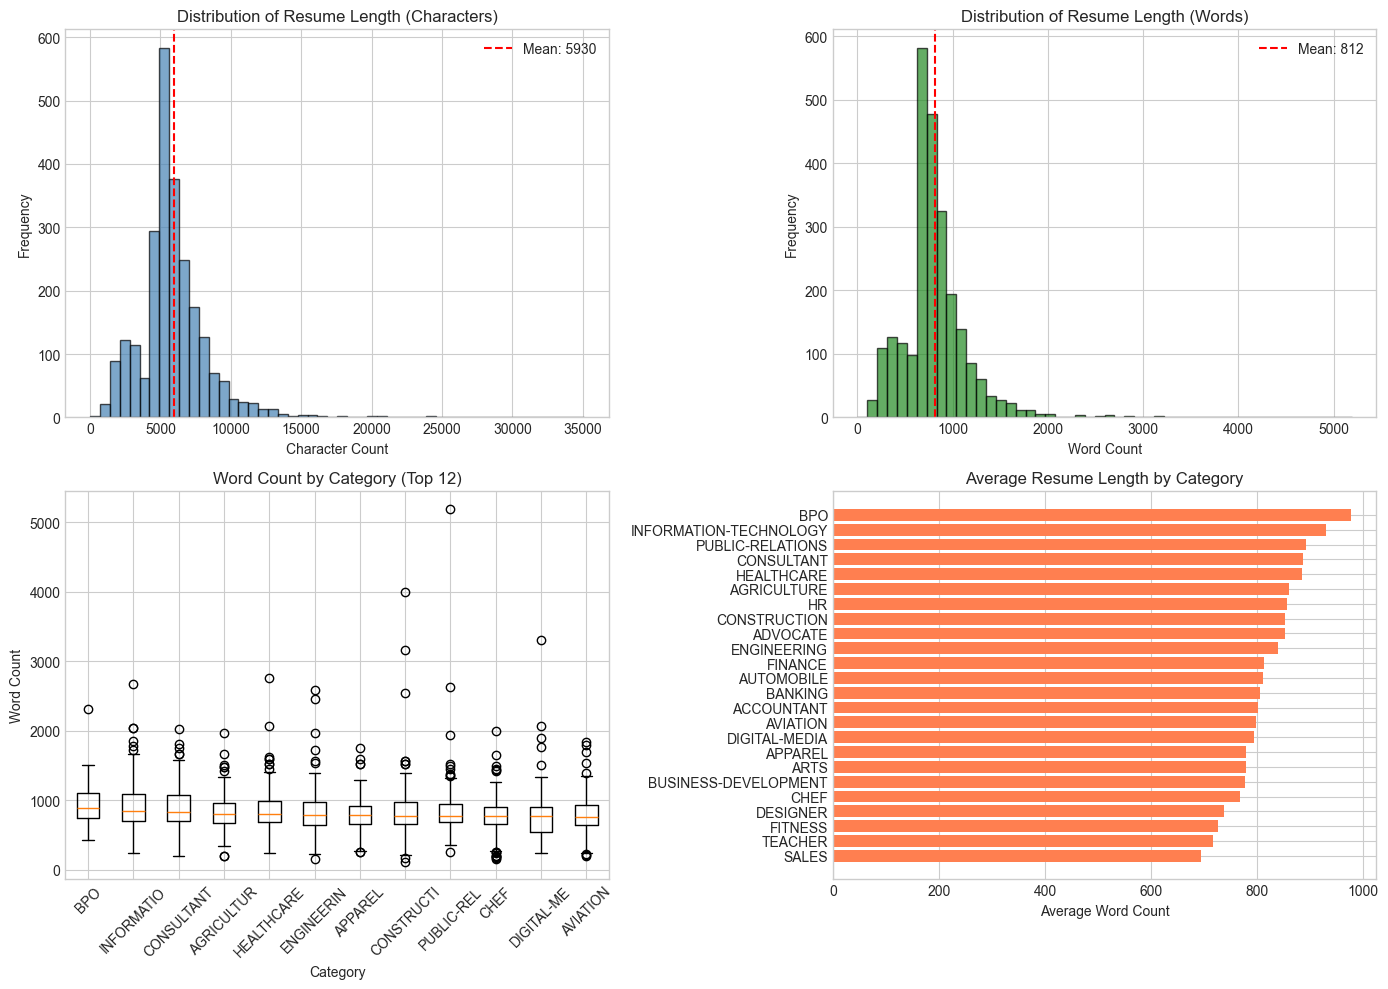

In [15]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Character count distribution
axes[0, 0].hist(df['Char_Count'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['Char_Count'].mean(), color='red', linestyle='--', label=f'Mean: {df["Char_Count"].mean():.0f}')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Resume Length (Characters)')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(df['Word_Count'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['Word_Count'].mean(), color='red', linestyle='--', label=f'Mean: {df["Word_Count"].mean():.0f}')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Resume Length (Words)')
axes[0, 1].legend()

# Word count by category (boxplot)
category_order = df.groupby('Category')['Word_Count'].median().sort_values(ascending=False).index
df_plot = df.copy()
df_plot['Category'] = pd.Categorical(df_plot['Category'], categories=category_order, ordered=True)
df_plot_sorted = df_plot.sort_values('Category')

axes[1, 0].boxplot([df[df['Category'] == cat]['Word_Count'].values for cat in category_order[:12]], 
                   labels=[cat[:10] for cat in category_order[:12]])
axes[1, 0].set_xlabel('Category')
axes[1, 0].set_ylabel('Word Count')
axes[1, 0].set_title('Word Count by Category (Top 12)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Average word length by category
avg_by_cat = df.groupby('Category')['Word_Count'].mean().sort_values(ascending=True)
axes[1, 1].barh(avg_by_cat.index, avg_by_cat.values, color='coral')
axes[1, 1].set_xlabel('Average Word Count')
axes[1, 1].set_title('Average Resume Length by Category')

plt.tight_layout()
plt.show()

---
## 5. Section Pattern Detection

Analyze common section headers to help with section classification.

In [16]:
# Common section header patterns
section_patterns = {
    'EXPERIENCE': r'(?i)(work\s*experience|professional\s*experience|employment|work\s*history|experience)',
    'EDUCATION': r'(?i)(education|academic|qualification|degree)',
    'SKILLS': r'(?i)(skills|technical\s*skills|competencies|expertise|proficiencies)',
    'SUMMARY': r'(?i)(summary|objective|profile|about\s*me|career\s*objective)',
    'PROJECTS': r'(?i)(projects|personal\s*projects|academic\s*projects)',
    'CERTIFICATIONS': r'(?i)(certification|certificate|licensed|accreditation)',
    'CONTACT': r'(?i)(contact|email|phone|address)',
    'ACHIEVEMENTS': r'(?i)(achievement|award|honor|accomplishment)',
    'REFERENCES': r'(?i)(reference|referees)'
}

# Count section occurrences
section_counts = {}
for section, pattern in section_patterns.items():
    count = df['Clean_Text'].str.contains(pattern, regex=True).sum()
    section_counts[section] = count

section_df = pd.DataFrame({
    'Section': section_counts.keys(),
    'Count': section_counts.values(),
    'Percentage': [c/len(df)*100 for c in section_counts.values()]
}).sort_values('Count', ascending=False)

print("Section Header Detection:")
print(section_df.to_string(index=False))

Section Header Detection:
       Section  Count  Percentage
    EXPERIENCE   2483   99.959742
        SKILLS   2469   99.396135
     EDUCATION   2467   99.315620
       SUMMARY   2233   89.895330
  ACHIEVEMENTS   1524   61.352657
       CONTACT   1354   54.508857
      PROJECTS   1054   42.431562
CERTIFICATIONS    982   39.533011
    REFERENCES    247    9.943639


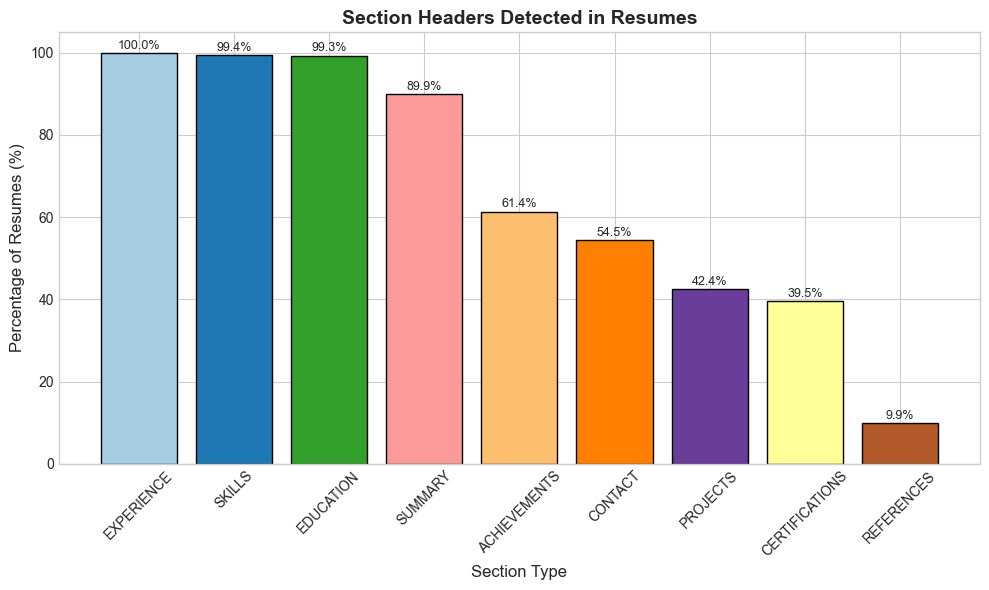

In [17]:
# Visualize section detection
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.Paired(np.linspace(0, 1, len(section_df)))
bars = ax.bar(section_df['Section'], section_df['Percentage'], color=colors, edgecolor='black')

ax.set_xlabel('Section Type', fontsize=12)
ax.set_ylabel('Percentage of Resumes (%)', fontsize=12)
ax.set_title('Section Headers Detected in Resumes', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

# Add percentage labels
for bar, pct in zip(bars, section_df['Percentage']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{pct:.1f}%', 
            ha='center', fontsize=9)

plt.tight_layout()
plt.show()

---
## 6. Entity Pattern Detection

Detect common entity patterns (emails, phones, dates, etc.)

In [18]:
# Entity patterns
entity_patterns = {
    'Email': r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',
    'Phone': r'\b(?:\+?1[-.]?)?\(?\d{3}\)?[-.]?\d{3}[-.]?\d{4}\b',
    'LinkedIn': r'(?i)linkedin\.com/in/[a-zA-Z0-9-]+',
    'Date_Range': r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s*\d{4}\s*[-–to]+\s*(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec|Present|Current)[a-z]*\s*\d{0,4}',
    'Year': r'\b(19|20)\d{2}\b',
    'Degree': r'(?i)\b(bachelor|master|phd|doctorate|associate|b\.?s\.?|m\.?s\.?|b\.?a\.?|m\.?a\.?|mba)\b',
    'GPA': r'(?i)gpa[:\s]*[0-3]?\.[0-9]+',
    'Percentage': r'\b\d{1,3}(?:\.\d+)?\s*%'
}

# Detect entities
entity_stats = {}
for entity, pattern in entity_patterns.items():
    matches = df['Resume_text'].str.findall(pattern)
    total_found = matches.str.len().sum()
    resumes_with = (matches.str.len() > 0).sum()
    entity_stats[entity] = {
        'Total Found': total_found,
        'Resumes With': resumes_with,
        'Coverage %': resumes_with / len(df) * 100
    }

entity_df = pd.DataFrame(entity_stats).T
entity_df = entity_df.sort_values('Total Found', ascending=False)
print("Entity Detection Results:")
print(entity_df.round(2))

Entity Detection Results:
            Total Found  Resumes With  Coverage %
Year            32632.0        2477.0       99.72
Degree           5556.0        2113.0       85.06
Date_Range       5133.0        1146.0       46.14
Percentage       2448.0         829.0       33.37
GPA               568.0         252.0       10.14
Phone              93.0          43.0        1.73
Email              37.0          19.0        0.76
LinkedIn           23.0          21.0        0.85


In [19]:
# Sample extracted entities
print("\nSample Extracted Entities:")
print("=" * 50)

sample_resume = df['Resume_text'].iloc[5]

for entity, pattern in entity_patterns.items():
    matches = re.findall(pattern, sample_resume)
    if matches:
        print(f"\n{entity}: {matches[:5]}")


Sample Extracted Entities:

Year: ['20', '20', '20', '20', '20']

Degree: ['Master', 'Bachelor', 'Associate']

Percentage: ['95%']


---
## 7. Skills Analysis

In [20]:
# Common technical skills to look for
tech_skills = [
    'python', 'java', 'javascript', 'sql', 'excel', 'c\\+\\+', 'html', 'css',
    'react', 'node', 'aws', 'azure', 'docker', 'kubernetes', 'git',
    'machine learning', 'data analysis', 'tableau', 'power bi', 'sap',
    'salesforce', 'photoshop', 'autocad', 'matlab', 'r\\b', 'scala',
    'tensorflow', 'pytorch', 'mongodb', 'postgresql', 'mysql'
]

# Soft skills
soft_skills = [
    'communication', 'leadership', 'teamwork', 'problem solving', 'analytical',
    'management', 'organization', 'presentation', 'negotiation', 'customer service',
    'time management', 'adaptable', 'creative', 'detail oriented', 'strategic'
]

# Count skill mentions
def count_skills(text, skills_list):
    text_lower = text.lower()
    found = []
    for skill in skills_list:
        if re.search(r'\b' + skill + r'\b', text_lower):
            found.append(skill.replace('\\', ''))
    return found

df['Tech_Skills'] = df['Clean_Text'].apply(lambda x: count_skills(x, tech_skills))
df['Soft_Skills'] = df['Clean_Text'].apply(lambda x: count_skills(x, soft_skills))
df['Tech_Skills_Count'] = df['Tech_Skills'].str.len()
df['Soft_Skills_Count'] = df['Soft_Skills'].str.len()

In [21]:
# Most common technical skills
all_tech_skills = [skill for skills in df['Tech_Skills'] for skill in skills]
tech_skill_counts = Counter(all_tech_skills).most_common(20)

print("Top 20 Technical Skills:")
for skill, count in tech_skill_counts:
    pct = count / len(df) * 100
    print(f"  {skill}: {count} ({pct:.1f}%)")

Top 20 Technical Skills:
  excel: 959 (38.6%)
  photoshop: 206 (8.3%)
  rb: 196 (7.9%)
  sap: 188 (7.6%)
  sql: 178 (7.2%)
  html: 140 (5.6%)
  data analysis: 126 (5.1%)
  autocad: 103 (4.1%)
  salesforce: 98 (3.9%)
  java: 67 (2.7%)
  css: 64 (2.6%)
  javascript: 55 (2.2%)
  python: 40 (1.6%)
  mysql: 39 (1.6%)
  matlab: 35 (1.4%)
  tableau: 26 (1.0%)
  aws: 22 (0.9%)
  machine learning: 12 (0.5%)
  azure: 11 (0.4%)
  git: 10 (0.4%)


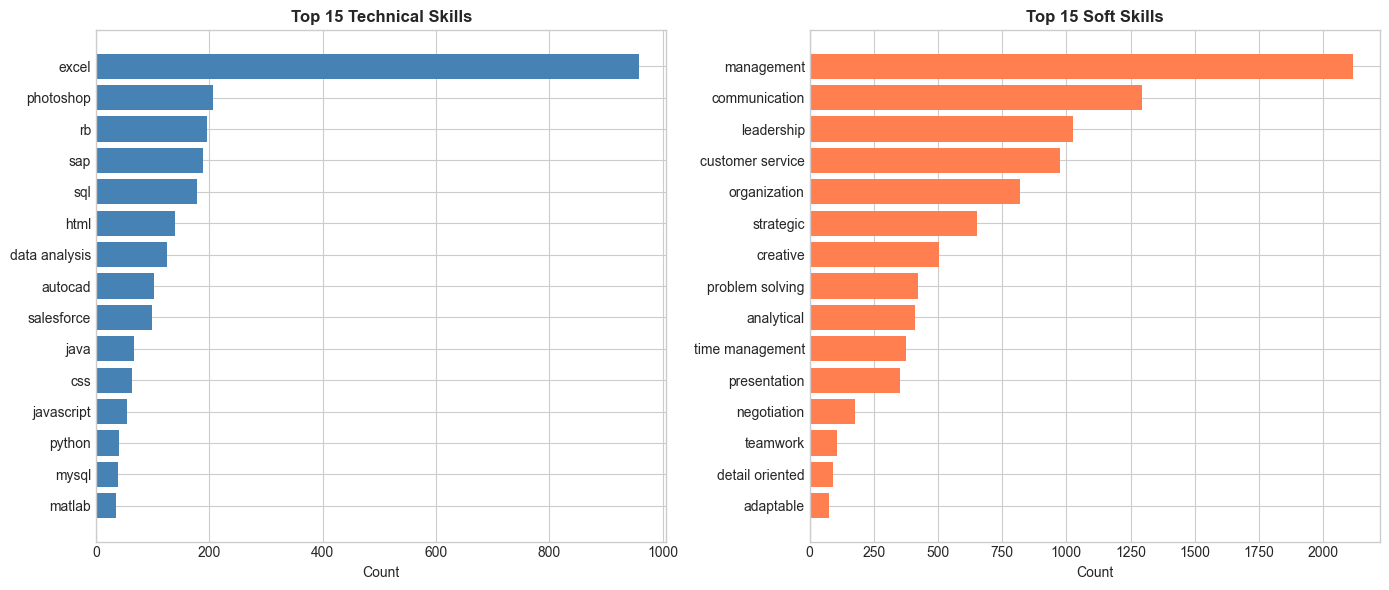

In [22]:
# Visualize top skills
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Technical skills
tech_df = pd.DataFrame(tech_skill_counts[:15], columns=['Skill', 'Count'])
axes[0].barh(tech_df['Skill'], tech_df['Count'], color='steelblue')
axes[0].set_xlabel('Count')
axes[0].set_title('Top 15 Technical Skills', fontweight='bold')
axes[0].invert_yaxis()

# Soft skills
all_soft_skills = [skill for skills in df['Soft_Skills'] for skill in skills]
soft_skill_counts = Counter(all_soft_skills).most_common(15)
soft_df = pd.DataFrame(soft_skill_counts, columns=['Skill', 'Count'])
axes[1].barh(soft_df['Skill'], soft_df['Count'], color='coral')
axes[1].set_xlabel('Count')
axes[1].set_title('Top 15 Soft Skills', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [23]:
# Skills by category
skills_by_category = df.groupby('Category').agg({
    'Tech_Skills_Count': 'mean',
    'Soft_Skills_Count': 'mean'
}).round(2).sort_values('Tech_Skills_Count', ascending=False)

print("Average Skills Count by Category:")
print(skills_by_category)

Average Skills Count by Category:
                        Tech_Skills_Count  Soft_Skills_Count
Category                                                    
INFORMATION-TECHNOLOGY               1.89               3.59
ENGINEERING                          1.88               2.95
DESIGNER                             1.68               3.15
DIGITAL-MEDIA                        1.64               3.99
CONSULTANT                           1.59               3.74
AUTOMOBILE                           1.31               3.72
ACCOUNTANT                           1.29               3.36
BANKING                              1.17               4.19
FINANCE                              1.10               4.19
BPO                                  1.09               4.09
AGRICULTURE                          1.05               3.68
HR                                   1.01               4.28
PUBLIC-RELATIONS                     0.95               4.61
AVIATION                             0.91          

---
## 8. Category-Specific Analysis

In [24]:
# Analyze specific category keywords
def get_top_words(category, n=20):
    """Get most common words for a category (excluding common stopwords)"""
    stopwords = {'the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'with', 'as', 'at', 'by', 'an', 'be', 
                 'this', 'that', 'are', 'was', 'were', 'been', 'have', 'has', 'had', 'do', 'does', 'did',
                 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'shall', 'can', 'need',
                 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'my', 'your', 'his', 'her', 'its', 'our',
                 'from', 'or', 'but', 'not', 'all', 'more', 'some', 'any', 'each', 'which', 'their',
                 'email', 'phone', 'also', 'using', 'used', 'work', 'working', 'worked'}
    
    cat_text = ' '.join(df[df['Category'] == category]['Clean_Text'].values)
    words = re.findall(r'\b[a-zA-Z]{3,}\b', cat_text.lower())
    words = [w for w in words if w not in stopwords]
    return Counter(words).most_common(n)

# Analyze a few key categories
categories_to_analyze = ['INFORMATION-TECHNOLOGY', 'HEALTHCARE', 'FINANCE', 'ENGINEERING', 'SALES']

for cat in categories_to_analyze:
    print(f"\n{'='*50}")
    print(f"Top Keywords for {cat}:")
    print('='*50)
    top_words = get_top_words(cat, 15)
    for word, count in top_words:
        print(f"  {word}: {count}")


Top Keywords for INFORMATION-TECHNOLOGY:
  management: 895
  information: 860
  systems: 743
  technology: 739
  support: 673
  network: 669
  company: 651
  state: 638
  city: 616
  system: 585
  project: 565
  data: 558
  business: 553
  software: 541
  name: 521

Top Keywords for HEALTHCARE:
  state: 830
  city: 743
  company: 682
  management: 679
  name: 562
  care: 543
  healthcare: 476
  patient: 474
  medical: 468
  customer: 428
  skills: 407
  health: 397
  business: 384
  sales: 349
  new: 335

Top Keywords for FINANCE:
  financial: 1113
  company: 790
  management: 787
  finance: 771
  state: 746
  city: 692
  accounting: 665
  business: 613
  name: 544
  analysis: 435
  accounts: 388
  reporting: 381
  sales: 375
  monthly: 345
  skills: 328

Top Keywords for ENGINEERING:
  engineering: 971
  company: 653
  city: 643
  state: 632
  management: 522
  project: 514
  name: 510
  systems: 436
  team: 408
  design: 408
  equipment: 396
  process: 378
  development: 337
  skill

---
## 9. Data Quality Assessment

In [25]:
# Check for potential data quality issues
print("Data Quality Report")
print("=" * 50)

# Very short resumes
short_resumes = df[df['Word_Count'] < 50]
print(f"\nVery short resumes (<50 words): {len(short_resumes)} ({len(short_resumes)/len(df)*100:.1f}%)")

# Very long resumes
long_resumes = df[df['Word_Count'] > 1500]
print(f"Very long resumes (>1500 words): {len(long_resumes)} ({len(long_resumes)/len(df)*100:.1f}%)")

# Resumes without detected email
no_email = df['Resume_text'].str.contains(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', regex=True)
print(f"Resumes without email: {(~no_email).sum()} ({(~no_email).sum()/len(df)*100:.1f}%)")

# Resumes without experience section
no_exp = ~df['Clean_Text'].str.contains(r'(?i)(experience|employment|work history)', regex=True)
print(f"Resumes without experience section: {no_exp.sum()} ({no_exp.sum()/len(df)*100:.1f}%)")

# Resumes without education section
no_edu = ~df['Clean_Text'].str.contains(r'(?i)(education|academic|degree)', regex=True)
print(f"Resumes without education section: {no_edu.sum()} ({no_edu.sum()/len(df)*100:.1f}%)")

Data Quality Report

Very short resumes (<50 words): 1 (0.0%)
Very long resumes (>1500 words): 100 (4.0%)
Resumes without email: 2465 (99.2%)
Resumes without experience section: 1 (0.0%)
Resumes without education section: 19 (0.8%)


In [26]:
# Sample a problematic resume (very short)
if len(short_resumes) > 0:
    print("\nSample of a very short resume:")
    print("-" * 50)
    print(short_resumes['Clean_Text'].iloc[0])


Sample of a very short resume:
--------------------------------------------------



---
## 10. Summary Statistics

In [27]:
# Final summary
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"\nTotal Resumes: {len(df):,}")
print(f"Categories: {df['Category'].nunique()}")
print(f"\nText Statistics:")
print(f"  - Average Word Count: {df['Word_Count'].mean():.0f}")
print(f"  - Median Word Count: {df['Word_Count'].median():.0f}")
print(f"  - Min Word Count: {df['Word_Count'].min()}")
print(f"  - Max Word Count: {df['Word_Count'].max()}")
print(f"\nSection Detection:")
print(f"  - Experience section: {(df['Clean_Text'].str.contains('(?i)experience', regex=True)).sum()/len(df)*100:.1f}%")
print(f"  - Education section: {(df['Clean_Text'].str.contains('(?i)education', regex=True)).sum()/len(df)*100:.1f}%")
print(f"  - Skills section: {(df['Clean_Text'].str.contains('(?i)skills', regex=True)).sum()/len(df)*100:.1f}%")
print(f"\nEntity Detection:")
print(f"  - Resumes with email: {no_email.sum()/len(df)*100:.1f}%")
print(f"\nSkills:")
print(f"  - Avg Technical Skills: {df['Tech_Skills_Count'].mean():.1f}")
print(f"  - Avg Soft Skills: {df['Soft_Skills_Count'].mean():.1f}")

DATASET SUMMARY

Total Resumes: 2,484
Categories: 24

Text Statistics:
  - Average Word Count: 812
  - Median Word Count: 760
  - Min Word Count: 0
  - Max Word Count: 5190

Section Detection:
  - Experience section: 97.8%
  - Education section: 99.1%
  - Skills section: 99.0%

Entity Detection:
  - Resumes with email: 0.8%

Skills:
  - Avg Technical Skills: 1.0
  - Avg Soft Skills: 3.8


---
## 11. Export Processed Data

In [28]:
# Export processed dataframe with all features
export_cols = ['ID', 'Category', 'Clean_Text', 'Word_Count', 'Char_Count', 'Tech_Skills', 'Soft_Skills']

df[export_cols].to_csv(PROCESSED_PATH + 'Resume_Processed.csv', index=False)
print("Exported 'Resume_Processed.csv' with all computed features!")

Exported 'Resume_Processed.csv' with all computed features!


In [29]:
df[export_cols].head()

,ID,Category,Clean_Text,Word_Count,Char_Count,Tech_Skills,Soft_Skills
0,37201447,AGRICULTURE,ADULT EDUCATION INSTRUCTOR Summary Seasoned Agriculture Teacher with more than 20 years of experience in this world of education. Excellent teaching and leadership skills. Track record of achievin...,795,5710,[],"[communication, leadership]"
1,12674256,AGRICULTURE,FINANCIAL SALES CONSULTANT Professional Summary Articulate Project Manager driven to succeed. Strategic planning and client relationship management expert. Core Qualifications Written Communicatio...,823,5425,[],"[management, organization, customer service, strategic]"
2,29968330,AGRICULTURE,"EXTENSION METHODOLOGIST Profile Self-motivated, honest, competent, innovative and easily adapt to new ideas. The knowledge and experience I have evidently accumulated through my academics at vario...",823,5591,[excel],"[analytical, management, organization]"
3,81042872,AGRICULTURE,RESEARCH SCIENTIST Summary Highly motivated Research Scientist possessing proficiency in numerous disciplines of the biotechnology and in-vitro diagnostic ( IVD ) industry. Self starter â€¢knowled...,783,5711,"[excel, rb]","[communication, analytical, management, organization, presentation, adaptable]"
4,20006992,AGRICULTURE,"FRONT DESK CLERK (FEE BASIS, JOHN D DINGELL VA MEDICAL CENTER) Summary Passionate, results-oriented Customer Service Representative Â with diverse background in management and customer service. De...",738,5281,[],"[leadership, management, customer service]"
